In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline
import cufflinks as cf
import plotly.plotly as py
import plotly.figure_factory as ff
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot
init_notebook_mode(connected=True)
cf.go_offline()

IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.


In [225]:
from sklearn.model_selection import cross_val_score
from sklearn.preprocessing import StandardScaler,MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression,Ridge,Lasso,ElasticNet,SGDRegressor
from sklearn.metrics import mean_absolute_error,mean_squared_error
from sklearn import decomposition
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestRegressor

# Importing cleaned up data-set

After the process of data munging and exploratory data analysis, I was able to create a cleaned up data set

In [227]:
df = pd.read_csv('../data/train_clean.csv')

In [228]:
df.columns

Index(['bedrooms_total', 'baths_total', 'acres', 'sq_ft_tot_fn',
       'tax_gross_amount', 'assessment_value_town', 'garage_capacity',
       'year_built', 'total_stories', 'rooms_total', 'garage', 'flood_zone',
       'basement', 'price_closed', 'city__Pomfret', 'city__Woodstock',
       'covenants__Unknown', 'covenants__Yes', 'garage_type', 'short_sale',
       'basement_access_type', 'current_use'],
      dtype='object')

In [229]:
df.head()

,bedrooms_total,baths_total,acres,sq_ft_tot_fn,tax_gross_amount,assessment_value_town,garage_capacity,year_built,total_stories,rooms_total,...,basement,price_closed,city__Pomfret,city__Woodstock,covenants__Unknown,covenants__Yes,garage_type,short_sale,basement_access_type,current_use
0,3.0,3.0,1.58,3740.0,11044.0,538200.0,2.0,1970.0,2.0,14.0,...,1.0,495000.0,0.0,1.0,1.0,0.0,2.0,0.0,0.0,0.000000
1,4.0,3.0,5.19,2276.0,13438.0,696500.0,2.0,1990.0,2.0,9.0,...,0.0,540000.0,0.0,1.0,0.0,0.0,1.0,1.0,1.0,0.053388
2,4.0,3.0,0.84,2200.0,6361.0,329700.0,1.0,1800.0,2.0,10.0,...,1.0,460000.0,0.0,1.0,0.0,0.0,3.0,1.0,0.0,0.000000
3,3.0,3.0,15.40,2926.0,11829.0,697600.0,2.0,1995.0,2.0,7.0,...,1.0,500000.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.000000
4,4.0,5.0,4.00,2817.0,10707.0,512100.0,2.0,1968.0,1.5,6.0,...,1.0,605914.0,0.0,1.0,0.0,1.0,1.0,0.0,0.0,0.045406


In [11]:
df.iloc[0]

bedrooms_total                3.00
baths_total                   3.00
acres                         1.58
sq_ft_tot_fn               3740.00
tax_gross_amount          11044.00
assessment_value_town    538200.00
garage_capacity               2.00
year_built                 1970.00
total_stories                 2.00
rooms_total                  14.00
garage                        1.00
flood_zone                    0.00
basement                      1.00
price_closed             495000.00
city__Pomfret                 0.00
city__Woodstock               1.00
covenants__Unknown            1.00
covenants__Yes                0.00
garage_type                   2.00
short_sale                    0.00
basement_access_type          0.00
current_use                   0.00
Name: 0, dtype: float64

## Further Data Analysis

In [13]:
df.iplot(kind='scatter',x='year_built', y='price_closed', mode='markers', xTitle='Year',yTitle='Price Closed')

Thus, we can see that Year is potentially a useful feature for our prediction. However, since its range is different than the rest, we might need to scale the dataframe

In [17]:
df[['assessment_value_town','price_closed']].iplot(kind='spread',title='Assessment Value By Town')

An assessment is the value placed on a property by the town or city's assessor's office for the purpose of determining the property tax due. Some of the assessment values follow closely the price closed

In [39]:
df.iplot(kind='scatter',x='sq_ft_tot_fn',y='price_closed',colorscale='set2',mode='markers',symbol='x',xTitle='Square Feet Total',yTitle='Price Closed')

In [68]:
fig = ff.create_distplot([list(df['tax_gross_amount'])],group_labels=['Tax Gross Amount'],bin_size=1000,show_rug=False,colors='set2')
fig.iplot()

In [126]:
fig = ff.create_distplot([list(df['price_closed'])],group_labels=['Closing Price'],bin_size=50000,show_rug=False,colors='set2')
fig.iplot()

In [152]:
df.iplot(kind='scatter',x='acres',y='price_closed',colorscale='set2',mode='markers',symbol='x',xTitle='Acres',yTitle='Price Closed')

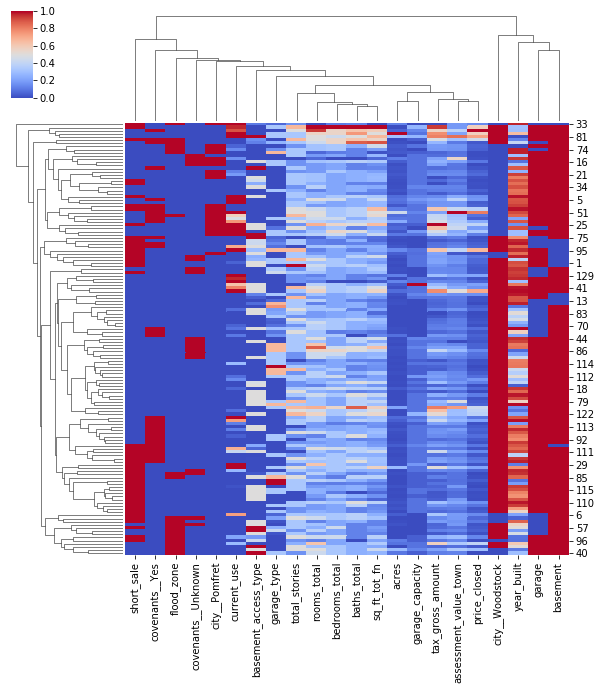

In [69]:
sns.clustermap(df,cmap='coolwarm',standard_scale=1)

In [10]:
target = df['price_closed']

In [11]:
df.drop('price_closed', axis=1,inplace=True)

In [12]:
df = pd.concat([df,target],axis=1)

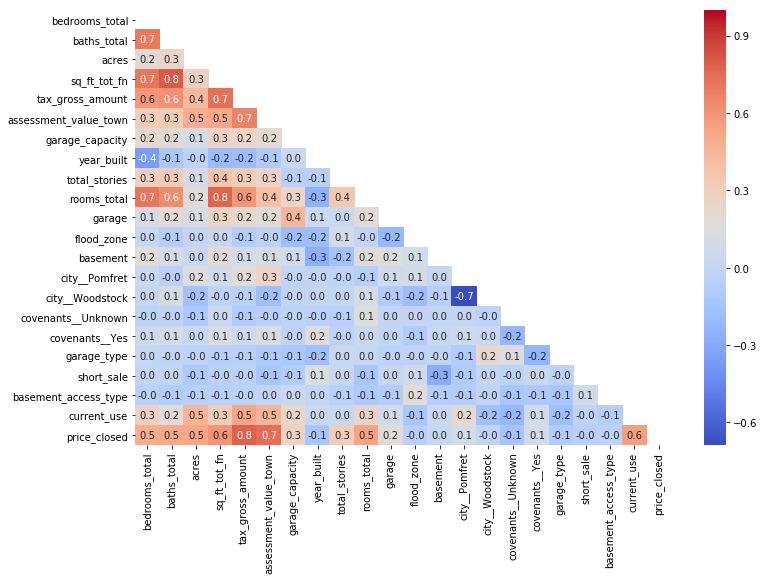

In [118]:
correlation = df.corr()
mask = np.zeros_like(correlation, dtype=np.bool)
mask[np.triu_indices_from(mask)]=True
plt.figure(figsize=(12,8))
sns.heatmap(correlation,mask=mask,fmt='.1f', annot=True,cmap='coolwarm') 

# Data Preprocessing

In [14]:
scaler= StandardScaler()
scaled_features = scaler.fit_transform(df.drop('price_closed',axis=1))

In [6]:
columns = [x for x in df.columns if x !='price_closed']

In [7]:
columns

['bedrooms_total',
 'baths_total',
 'acres',
 'sq_ft_tot_fn',
 'tax_gross_amount',
 'assessment_value_town',
 'garage_capacity',
 'year_built',
 'total_stories',
 'rooms_total',
 'garage',
 'flood_zone',
 'basement',
 'city__Pomfret',
 'city__Woodstock',
 'covenants__Unknown',
 'covenants__Yes',
 'garage_type',
 'short_sale',
 'basement_access_type',
 'current_use']

In [26]:
df_features = pd.DataFrame(scaled_features, columns = [x for x in df.columns if x !='price_closed'])
df_features.describe()

,bedrooms_total,baths_total,acres,sq_ft_tot_fn,tax_gross_amount,assessment_value_town,garage_capacity,year_built,total_stories,rooms_total,...,flood_zone,basement,city__Pomfret,city__Woodstock,covenants__Unknown,covenants__Yes,garage_type,short_sale,basement_access_type,current_use
count,1.370000e+02,1.370000e+02,1.370000e+02,1.370000e+02,1.370000e+02,1.370000e+02,1.370000e+02,1.370000e+02,1.370000e+02,1.370000e+02,...,1.370000e+02,1.370000e+02,137.000000,1.370000e+02,1.370000e+02,1.370000e+02,1.370000e+02,1.370000e+02,1.370000e+02,1.370000e+02
mean,-7.009802e-17,1.653179e-16,-3.727756e-17,-1.734217e-16,1.831463e-16,-2.123200e-16,1.557959e-16,9.440948e-16,4.862291e-17,2.188031e-16,...,-4.376062e-17,-6.402016e-17,0.000000,-8.752123e-17,-1.199365e-16,-2.431145e-17,1.029185e-16,-7.293436e-17,7.698627e-17,5.834749e-17
std,1.003670e+00,1.003670e+00,1.003670e+00,1.003670e+00,1.003670e+00,1.003670e+00,1.003670e+00,1.003670e+00,1.003670e+00,1.003670e+00,...,1.003670e+00,1.003670e+00,1.003670,1.003670e+00,1.003670e+00,1.003670e+00,1.003670e+00,1.003670e+00,1.003670e+00,1.003670e+00
min,-2.323442e+00,-1.689135e+00,-4.070189e-01,-1.694819e+00,-1.066873e+00,-1.311725e+00,-8.475875e-01,-1.992564e+00,-1.780947e+00,-1.972280e+00,...,-4.254815e-01,-2.851900e+00,-0.425481,-1.614083e+00,-4.012692e-01,-5.520524e-01,-7.363811e-01,-7.343881e-01,-7.847720e-01,-5.922698e-01
25%,-5.501186e-01,-9.304089e-01,-3.887400e-01,-6.902584e-01,-6.799077e-01,-6.044079e-01,-3.732176e-01,-1.049876e+00,-8.425250e-01,-8.401471e-01,...,-4.254815e-01,3.506434e-01,-0.425481,-1.614083e+00,-4.012692e-01,-5.520524e-01,-7.363811e-01,-7.343881e-01,-7.847720e-01,-5.922698e-01
50%,-5.501186e-01,-1.716826e-01,-3.147859e-01,-1.374024e-01,-3.072027e-01,-3.156055e-01,1.011524e-01,5.301228e-01,9.589716e-02,-8.539200e-02,...,-4.254815e-01,3.506434e-01,-0.425481,6.195469e-01,-4.012692e-01,-5.520524e-01,-6.705057e-01,-7.343881e-01,-7.847720e-01,-5.922698e-01
75%,3.365431e-01,5.870437e-01,-7.129070e-02,4.671874e-01,1.718513e-01,1.865450e-01,1.011524e-01,8.620553e-01,9.589716e-02,6.693631e-01,...,-4.254815e-01,3.506434e-01,-0.425481,6.195469e-01,-4.012692e-01,-5.520524e-01,6.408015e-01,1.361678e+00,9.238186e-01,2.562362e-04
max,5.656514e+00,4.380675e+00,9.034288e+00,4.327914e+00,3.919567e+00,5.691761e+00,9.588552e+00,1.074492e+00,3.849586e+00,4.065761e+00,...,2.350279e+00,3.506434e-01,2.350279,6.195469e-01,2.492093e+00,1.811422e+00,3.395167e+00,1.361678e+00,2.632409e+00,2.097604e+00


We can see that the standard deviation is the same, thus our scaler has worked

In [27]:
X = df_features
y = target

In [28]:
X_train,X_test,y_train,y_test= train_test_split(X,y,test_size=0.3,random_state=101)
lm = LinearRegression()
lm.fit(X_train,y_train)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False)

In [29]:
prediction = lm.predict(X_test)

Mean Absolute Error: 348645.8436439136
Mean Squared Error: 270973644920.2895
Root Mean Squared Error: 520551.28942332807


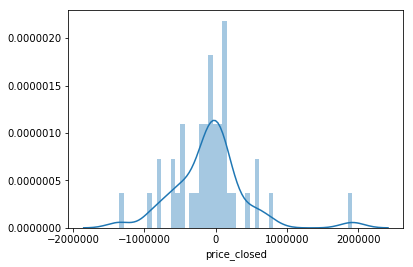

In [30]:
print('Mean Absolute Error: {}'.format(metrics.mean_absolute_error(y_test, prediction)))
print('Mean Squared Error: {}'.format(metrics.mean_squared_error(y_test, prediction)))
print('Root Mean Squared Error: {}'.format(np.sqrt(metrics.mean_squared_error(y_test, prediction))))
sns.distplot((y_test-prediction),bins=50) 

In [24]:
scores = cross_val_score(lm, X, y, cv=10, scoring='neg_mean_squared_error')
np.mean(np.sqrt(-scores))

421498.63610154501

Therefore, as we create more feature engineering the RMSE increases as opposed to our preliminary findings. However, our predictions are still normally distributed, so it's definitely still performing. As such,we might need to use principal component analysis to decompose our dataframe into meaningful latent features or components

In [27]:
pca = decomposition.PCA()
df_pca = pca.fit_transform(X)

In [154]:
pca.explained_variance_ratio_

array([ 0.23525152,  0.1035565 ,  0.08316376,  0.07447753,  0.06145056,
        0.05916209,  0.05563843,  0.04287536,  0.04128073,  0.036642  ,
        0.03340769,  0.03014869,  0.02869296,  0.02573217,  0.02021287,
        0.01855498,  0.01311871,  0.01256409,  0.0099863 ,  0.00891652,
        0.00516653])

In [156]:
pd.DataFrame(pca.components_, columns=df_features.columns)

,bedrooms_total,baths_total,acres,sq_ft_tot_fn,tax_gross_amount,assessment_value_town,garage_capacity,year_built,total_stories,rooms_total,...,flood_zone,basement,city__Pomfret,city__Woodstock,covenants__Unknown,covenants__Yes,garage_type,short_sale,basement_access_type,current_use
0,0.351789,0.350562,0.214704,0.403197,0.388543,0.309079,0.164786,-0.113041,0.178942,0.355730,...,-0.023844,0.092875,0.073334,-0.035351,-0.021928,0.052226,-0.031384,-0.049961,-0.045210,0.234348
1,-0.186793,-0.197454,0.247454,-0.112003,0.061822,0.225774,0.062144,0.194193,-0.133356,-0.233597,...,0.016193,-0.018629,0.474477,-0.483254,-0.162451,0.127123,-0.283402,-0.032916,0.030908,0.305457
2,0.089130,-0.068557,0.000605,0.023018,-0.020125,0.017287,-0.285162,-0.440458,0.060880,0.044235,...,0.465216,0.215196,0.290460,-0.324117,0.213807,-0.276078,0.168410,-0.158268,0.038705,-0.143228
3,-0.063841,-0.091379,-0.045654,-0.045085,-0.080648,-0.046831,0.356291,-0.109351,-0.350527,0.034731,...,-0.276218,0.415717,0.051238,-0.034739,0.258374,-0.155611,0.136036,-0.377699,-0.232310,-0.039272
4,-0.085524,0.020920,0.040868,0.003921,0.040393,0.035260,-0.035918,0.210094,0.261756,0.015149,...,-0.191442,-0.458974,0.212034,-0.159658,0.442376,-0.292589,0.309698,0.226439,-0.319182,-0.043149
5,0.069771,0.045222,-0.280742,0.105973,-0.047434,-0.121046,0.380570,0.028497,-0.015453,0.044577,...,0.226172,-0.052738,0.014207,-0.201446,0.107895,-0.235675,-0.260942,0.340715,0.490704,-0.175569
6,-0.099635,-0.150808,0.359679,-0.150084,0.125393,0.168372,0.160995,-0.130084,-0.045184,-0.111957,...,-0.016957,-0.135864,-0.205426,0.187950,-0.158231,-0.532807,0.291666,-0.060181,0.382277,0.270080
7,0.213713,0.027517,-0.009959,-0.048320,0.033495,-0.201515,-0.028665,-0.292899,-0.309942,-0.119174,...,-0.020487,0.090034,0.102612,-0.069784,-0.326313,0.052103,0.342085,0.602893,-0.231758,0.157241
8,0.092479,0.021953,0.105100,0.047129,0.039699,-0.010101,-0.043137,0.075041,-0.550996,0.111415,...,-0.008825,-0.022822,-0.109714,0.056220,0.553821,-0.011006,-0.216683,0.225334,0.042312,0.283850
9,-0.249005,-0.010950,0.422595,0.044555,-0.035925,0.209208,-0.138751,0.226858,0.010808,-0.058082,...,0.427849,0.320421,-0.227721,0.118307,0.185169,0.181239,0.128435,0.245609,-0.044016,-0.164021


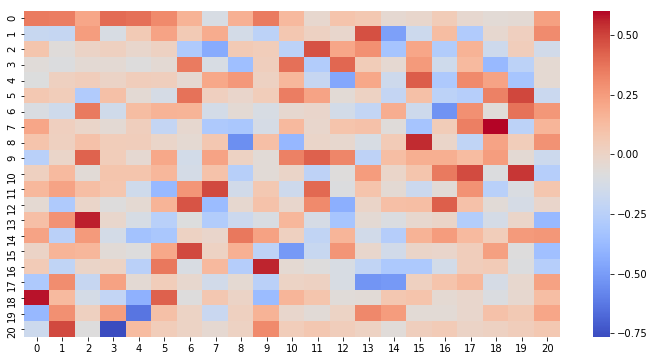

In [159]:
plt.figure(figsize=(12,6))
sns.heatmap(pca.components_, cmap='coolwarm')

In [158]:
fa = decomposition.FactorAnalysis().fit(X)
pd.DataFrame(fa.components_, columns=df_features.columns)

,bedrooms_total,baths_total,acres,sq_ft_tot_fn,tax_gross_amount,assessment_value_town,garage_capacity,year_built,total_stories,rooms_total,...,flood_zone,basement,city__Pomfret,city__Woodstock,covenants__Unknown,covenants__Yes,garage_type,short_sale,basement_access_type,current_use
0,0.769266,0.776658,0.400553,0.883212,0.820908,0.616042,0.315848,-0.240853,0.379413,0.780334,...,-0.035363,0.179104,0.116168,-0.034577,-0.020326,0.102320,-0.047987,-0.078928,-0.080754,0.448314
1,-0.195088,-0.221957,0.358219,-0.092537,0.166010,0.370163,0.069857,0.159699,-0.109645,-0.248428,...,0.032848,-0.007296,0.625965,-0.618082,-0.156705,0.090419,-0.268021,-0.062875,0.017630,0.413837
2,-0.135198,0.036911,0.099892,-0.043790,0.070939,0.065164,0.300652,0.431078,-0.078666,-0.073274,...,-0.466674,-0.195515,-0.287170,0.333210,-0.222720,0.223564,-0.143459,0.100251,-0.027159,0.226445
3,-0.011482,-0.060814,-0.091612,0.000458,-0.082679,-0.064471,0.379688,-0.109672,-0.299498,0.075523,...,-0.196032,0.380378,0.058029,-0.074904,0.221280,-0.126543,0.063286,-0.280014,-0.147728,-0.058293
4,-0.039083,-0.127649,0.270132,-0.109931,0.098313,0.165043,-0.092968,-0.253799,-0.075801,-0.017185,...,-0.027817,0.154867,-0.157717,0.225694,-0.076043,-0.152910,0.244369,-0.258734,-0.026052,0.183492
5,-0.095714,-0.001411,0.062349,-0.013335,0.044485,0.061962,-0.043861,0.096039,0.201214,0.021286,...,-0.162348,-0.284087,0.087606,-0.024207,0.313714,-0.254221,0.305318,0.051234,-0.223299,-0.054419
6,-0.003484,-0.053365,0.006981,-0.011236,0.040692,0.021894,0.227647,-0.072021,0.023599,-0.020811,...,0.156798,-0.108067,-0.095027,-0.011935,-0.020789,-0.333412,-0.006057,0.164420,0.390119,0.019033
7,0.153305,0.027343,-0.015456,-0.044015,0.014135,-0.155588,0.016822,-0.087622,-0.150275,-0.035579,...,-0.103197,-0.072927,0.067291,-0.039019,-0.086010,-0.056579,0.110979,0.175487,-0.083705,0.143210
8,-0.006998,0.035749,0.003685,-0.006195,0.016866,0.006501,-0.017032,-0.064801,0.103461,-0.079347,...,-0.008143,0.047150,0.030017,0.000969,-0.196438,0.031682,0.115125,0.013635,-0.016729,-0.098992
9,-0.020839,0.040181,0.081544,0.020697,0.000493,0.005250,-0.042293,0.037424,-0.090264,-0.032274,...,0.056217,0.054714,-0.023458,0.006446,0.056208,0.014401,0.039409,0.090597,0.001213,-0.018750


In [29]:
pca = decomposition.PCA(n_components=9)
df_pca = pca.fit_transform(X)

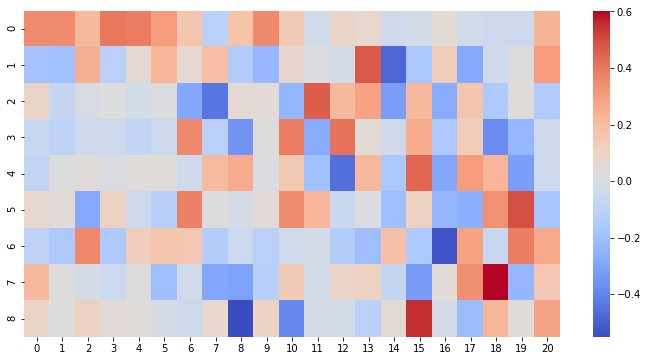

In [161]:
plt.figure(figsize=(12,6))
sns.heatmap(pca.components_, cmap='coolwarm')

When PCA contains all 20 components (still lower than original features)

In [28]:
scores = cross_val_score(lm, df_pca, y, cv=10, scoring='neg_mean_squared_error')
np.mean(np.sqrt(-scores))

421498.63610154449

When PCA contains only 9 components

In [25]:
scores = cross_val_score(lm, df_pca, y, cv=10, scoring='neg_mean_squared_error')
np.mean(np.sqrt(-scores))

382973.32450033259

In [56]:
rfg = RandomForestRegressor(max_depth=1000, random_state=42,n_estimators=1000)

In [18]:
rfg.fit(X_train,y_train)

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=10,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_split=1e-07, min_samples_leaf=1,
           min_samples_split=2, min_weight_fraction_leaf=0.0,
           n_estimators=10, n_jobs=1, oob_score=False, random_state=42,
           verbose=0, warm_start=False)

In [21]:
prediction = rfg.predict(X_test)

In [26]:
print(rfg.feature_importances_)

[  4.92772127e-03   5.76472191e-03   2.19215926e-02   3.23705241e-02
   8.15942689e-01   2.83100538e-02   4.36959527e-03   1.83683263e-02
   1.24874157e-02   1.37428568e-02   8.48417363e-05   2.19325905e-04
   1.36409173e-05   2.81445653e-04   1.83343301e-03   5.16325598e-06
   1.36473835e-02   9.73286596e-03   1.49031882e-03   6.21966445e-03
   8.26641966e-03]


Mean Absolute Error: 248539.93086734693
Mean Squared Error: 241622357773.04388
Root Mean Squared Error: 491550.97169372364


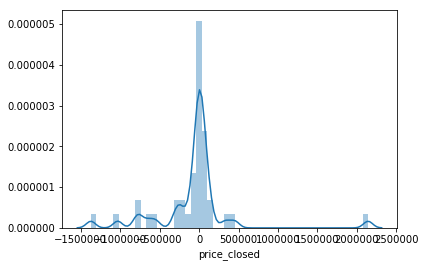

In [22]:
from sklearn import metrics
print('Mean Absolute Error: {}'.format(metrics.mean_absolute_error(y_test, prediction)))
print('Mean Squared Error: {}'.format(metrics.mean_squared_error(y_test, prediction)))
print('Root Mean Squared Error: {}'.format(np.sqrt(metrics.mean_squared_error(y_test, prediction))))
sns.distplot((y_test-prediction),bins=50) 

In [41]:
scores = cross_val_score(rfg, df_pca, y, cv=10, scoring='neg_mean_squared_error')
np.mean(np.sqrt(-scores))

381497.99812201376

In [42]:
scores = cross_val_score(rfg, X, y, cv=10, scoring='neg_mean_squared_error')
np.mean(np.sqrt(-scores))

386707.6120782519

In [44]:
rfg.fit(X,y)

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=1000,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_split=1e-07, min_samples_leaf=1,
           min_samples_split=2, min_weight_fraction_leaf=0.0,
           n_estimators=1000, n_jobs=1, oob_score=False, random_state=42,
           verbose=0, warm_start=False)

In [45]:
pd.DataFrame({'feature':df_features.columns, 'importance':rfg.feature_importances_}).sort_values('importance',ascending=False)

,feature,importance
4,tax_gross_amount,0.533564
5,assessment_value_town,0.147569
3,sq_ft_tot_fn,0.105922
2,acres,0.070372
9,rooms_total,0.036264
20,current_use,0.028906
7,year_built,0.018026
6,garage_capacity,0.015629
17,garage_type,0.006586
16,covenants__Yes,0.006170


In our preliminary exploration, we didn't include as many features as we did in the current model, yet we had a low RMSE. So I will attempt to run this model with the feature matrix from the preliminary exploration

In [259]:
X = df[['bedrooms_total', 'baths_total', 'acres', 'sq_ft_tot_fn',
       'tax_gross_amount', 'assessment_value_town', 'garage_capacity',
       'year_built', 'total_stories',
       'rooms_total', 'garage',
       'flood_zone',
       'basement', 'city__Pomfret', 'city__Woodstock',
       'covenants__Unknown', 'covenants__Yes']]
y = df['price_closed']

In [260]:
scaler= StandardScaler()
scaled_X = scaler.fit_transform(X)

In [261]:
X_train,X_test,y_train,y_test= train_test_split(scaled_X,y,test_size=0.3,random_state=101)

In [262]:
lm = LinearRegression()
lm.fit(X_train,y_train)
prediction = lm.predict(X_test)
print('Mean Absolute Error: {}'.format(mean_absolute_error(y_test, prediction)))
print('Mean Squared Error: {}'.format(mean_squared_error(y_test, prediction)))
print('Root Mean Squared Error: {}'.format(np.sqrt(mean_squared_error(y_test, prediction))))

Mean Absolute Error: 343112.28815630183
Mean Squared Error: 278340886333.6108
Root Mean Squared Error: 527580.217913457


In [263]:
from sklearn.model_selection import cross_val_score
scores = cross_val_score(lm, scaled_X, y, cv=10, scoring='neg_mean_squared_error')
np.mean(np.sqrt(-scores))

415103.77231883345

In [264]:
pca = decomposition.PCA()
df_pca = pca.fit_transform(scaled_X)

In [265]:
pca.explained_variance_ratio_

array([ 0.2763414 ,  0.11486992,  0.09722803,  0.08447743,  0.06987667,
        0.05759764,  0.05267359,  0.04491154,  0.04110787,  0.03584184,
        0.03119039,  0.02635808,  0.018435  ,  0.01708251,  0.01281111,
        0.01265946,  0.0065375 ])

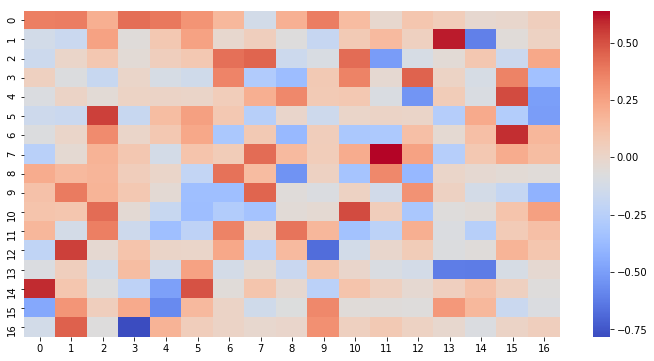

In [266]:
plt.figure(figsize=(12,6))
sns.heatmap(pca.components_, cmap='coolwarm')

In [267]:
pca_columns=['bedrooms_total', 'baths_total', 'acres', 'sq_ft_tot_fn',
       'tax_gross_amount', 'assessment_value_town', 'garage_capacity',
       'year_built', 'total_stories',
       'rooms_total', 'garage',
       'flood_zone',
       'basement', 'city__Pomfret', 'city__Woodstock',
       'covenants__Unknown', 'covenants__Yes']
fa = decomposition.FactorAnalysis().fit(scaled_X)
pd.DataFrame(fa.components_, columns=pca_columns)

,bedrooms_total,baths_total,acres,sq_ft_tot_fn,tax_gross_amount,assessment_value_town,garage_capacity,year_built,total_stories,rooms_total,garage,flood_zone,basement,city__Pomfret,city__Woodstock,covenants__Unknown,covenants__Yes
0,0.778426,0.792867,0.367775,0.890581,0.801915,0.589700,0.305954,-0.253450,0.392378,0.791044,0.267339,-0.023874,0.178993,0.092331,-0.013772,-0.002345,0.095944
1,-0.137856,-0.168844,0.312144,-0.032732,0.168664,0.361453,0.020479,0.058852,-0.048836,-0.195419,0.116688,0.118459,0.025952,0.696127,-0.681676,-0.063162,0.034309
2,-0.168450,0.019265,0.119791,-0.022756,0.085045,0.129188,0.401524,0.407128,-0.115678,-0.081913,0.407321,-0.471249,-0.107834,-0.114917,0.164839,-0.135339,0.166777
3,0.072640,-0.052771,-0.184119,0.018935,-0.120505,-0.162130,0.322768,-0.199753,-0.294234,0.091781,0.325418,-0.016966,0.355390,0.062884,-0.140933,0.234939,-0.188870
4,0.007454,0.091685,-0.211642,0.066344,-0.090843,-0.158109,0.006864,0.250874,0.183581,0.053194,0.057881,-0.031915,-0.284552,0.128673,-0.147149,0.199715,-0.028787
5,0.100538,0.098184,-0.103678,0.037269,-0.061289,-0.128075,-0.049824,0.081980,-0.151779,-0.047445,-0.046574,-0.008496,0.135535,0.085450,-0.054074,-0.244529,0.382466
6,-0.047404,-0.000914,0.024381,0.024955,-0.001915,0.057322,-0.097183,0.071237,-0.118715,0.042803,-0.075674,-0.064101,0.064326,0.006843,0.021825,0.225077,0.084898
7,-0.065304,-0.023382,-0.011450,0.031278,-0.037163,0.037387,0.002181,0.054402,0.083633,0.023075,0.068573,0.139823,0.083722,-0.046376,0.003122,-0.003283,0.063311
8,0.000000,0.000000,0.000000,0.000000,-0.000000,-0.000000,0.000000,0.000000,-0.000000,-0.000000,-0.000000,0.000000,-0.000000,-0.000000,-0.000000,0.000000,-0.000000
9,0.000000,-0.000000,-0.000000,-0.000000,-0.000000,0.000000,0.000000,0.000000,-0.000000,0.000000,-0.000000,0.000000,-0.000000,-0.000000,0.000000,0.000000,0.000000


From the above features matrix, I would run a loop and a Grid Search CV in order to find the best performing parameters of the number of principal components

In [268]:
n_params = np.arange(1,18)

In [269]:
performance_PCA = []
for n in n_params:
    pipe_PCA = Pipeline([('pca', decomposition.PCA(n_components=n)),
                 ('linear', LinearRegression())])
    scores = cross_val_score(pipe_PCA, scaled_X, y, cv=10, scoring='neg_mean_squared_error')
    performance_PCA.append(np.mean(np.sqrt(-scores)))

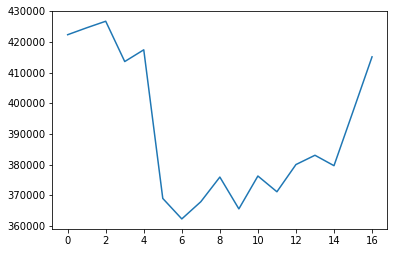

In [270]:
plt.plot(performance_PCA)

In [271]:
np.min(performance_PCA)

362297.97408611589

Now we try to run such model with our unscaled features

In [272]:
performance_PCA = []
for n in n_params:
    pipe_PCA = Pipeline([('pca', decomposition.PCA(n_components=n)),
                 ('linear', LinearRegression())])
    scores = cross_val_score(pipe_PCA, X, y, cv=10, scoring='neg_mean_squared_error')
    performance_PCA.append(np.mean(np.sqrt(-scores)))

In [273]:
np.min(performance_PCA)

372268.32211515447

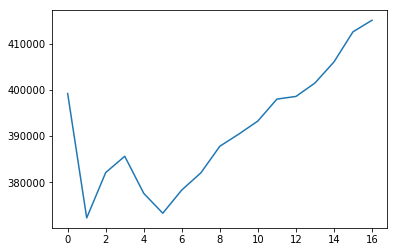

In [274]:
plt.plot(performance_PCA)

In [275]:
performance_PCA = []
for n in n_params:
    pca = decomposition.PCA(n_components=n)
    X_PCA =  pca.fit_transform(X)
    X_restored = pca.inverse_transform(X_PCA)
    scores = cross_val_score(LinearRegression(), X_restored, y, cv=10, scoring='neg_mean_squared_error')
    performance_PCA.append(np.mean(np.sqrt(-scores)))

In [276]:
print(np.min(performance_PCA))
print(np.argmin(performance_PCA))

372034.192544
5


In [277]:
param_grid = {'rf__max_depth': [5,10,100,1000], 'rf__n_estimators': [5,10,100,1000]}
rfg = RandomForestRegressor(max_depth=1000, random_state=42,n_estimators=1000)
pipeline = Pipeline([
    ('rf', RandomForestRegressor()),
])
grid = GridSearchCV(pipeline, param_grid, cv=10, scoring='neg_mean_squared_error')
grid.fit(X,y)

# poly = PolynomialFeatures(degree=2)
# poly.fit_transform(X)

GridSearchCV(cv=10, error_score='raise',
       estimator=Pipeline(steps=[('rf', RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_split=1e-07, min_samples_leaf=1,
           min_samples_split=2, min_weight_fraction_leaf=0.0,
           n_estimators=10, n_jobs=1, oob_score=False, random_state=None,
           verbose=0, warm_start=False))]),
       fit_params={}, iid=True, n_jobs=1,
       param_grid={'rf__max_depth': [5, 10, 100, 1000], 'rf__n_estimators': [5, 10, 100, 1000]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring='neg_mean_squared_error', verbose=0)

In [278]:
print (grid.best_score_)
print (grid.best_params_)

-180709594629.0
{'rf__max_depth': 10, 'rf__n_estimators': 10}


In [279]:
pca = decomposition.PCA(n_components=6)
X_PCA =  pca.fit_transform(X)
X_restored = pca.inverse_transform(X_PCA)
rfg = RandomForestRegressor(max_depth=10, random_state=42,n_estimators=10)
scores = cross_val_score(rfg, X_restored, y, cv=10, scoring='neg_mean_squared_error')
np.mean(np.sqrt(-scores))

410761.17271886359

In [280]:
rfg = RandomForestRegressor(max_depth=10, random_state=42,n_estimators=10)
scores = cross_val_score(rfg, X, y, cv=10, scoring='neg_mean_squared_error')
np.mean(np.sqrt(-scores))

402361.06530989142

In [281]:
from sklearn.preprocessing import PolynomialFeatures
pipeline = Pipeline([('poly', PolynomialFeatures(degree=2)),
                    ('linear', LinearRegression(fit_intercept=False, normalize=True))])
scores = cross_val_score(pipeline, X, y, cv=10, scoring='neg_mean_squared_error')
np.mean(np.sqrt(-scores))

6539862.2172484891

In [282]:
from sklearn.preprocessing import PolynomialFeatures
pipeline = Pipeline([('poly', PolynomialFeatures(degree=3)),
                    ('linear', LinearRegression(fit_intercept=False, normalize=True))])
scores = cross_val_score(pipeline, X, y, cv=10, scoring='neg_mean_squared_error')
np.mean(np.sqrt(-scores))

32511075.640909173

In [283]:
from sklearn.svm import SVR

In [284]:
svr_lin = SVR(kernel='linear')

In [285]:
svr_lin.fit(X, y)

SVR(C=1.0, cache_size=200, coef0=0.0, degree=3, epsilon=0.1, gamma='auto',
  kernel='linear', max_iter=-1, shrinking=True, tol=0.001, verbose=False)

In [286]:
prediction = svr_lin.predict(X)

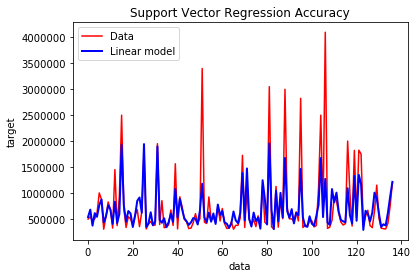

In [287]:
plt.plot(y, color='red', label='Data')
plt.plot(prediction, color='blue', lw=2, label='Linear model')
plt.xlabel('data')
plt.ylabel('target')
plt.title('Support Vector Regression Accuracy')
plt.legend()
plt.show()

Ridge Regression is a technique used when the data suffers from multicollinearity ( independent variables are highly correlated), Lasso

# Running models on Test Set

In [288]:
test = pd.read_csv('../data/test_clean.csv')

In [289]:
validate = pd.read_csv('../data/validate_clean.csv')['price_closed']

In [314]:
X_test = test[['bedrooms_total', 'baths_total', 'acres', 'sq_ft_tot_fn',
       'tax_gross_amount', 'assessment_value_town', 'garage_capacity',
       'year_built', 'total_stories',
       'rooms_total', 'garage',
       'flood_zone',
       'basement', 'city__Pomfret', 'city__Woodstock',
       'covenants__Unknown', 'covenants__Yes']]

In [315]:
lm = LinearRegression()
lm.fit(X,y)
prediction = lm.predict(X_test)

In [316]:
print('Mean Absolute Error: {}'.format(mean_absolute_error(validate, prediction)))
print('Mean Squared Error: {}'.format(mean_squared_error(validate, prediction)))
print('Root Mean Squared Error: {}'.format(np.sqrt(mean_squared_error(validate, prediction))))

Mean Absolute Error: 217188.67730153434
Mean Squared Error: 138041218018.69504
Root Mean Squared Error: 371538.98586648353


In [359]:
performance_PCA = []
for n in n_params:
    pca = decomposition.PCA(n_components=n)
    X_PCA =  pca.fit_transform(X)
    X_restored = pca.inverse_transform(X_PCA)
    scores = cross_val_score(RandomForestRegressor(max_depth=10, random_state=42,n_estimators=10), X_restored, y, cv=10, scoring='neg_mean_squared_error')
    performance_PCA.append(np.mean(np.sqrt(-scores)))

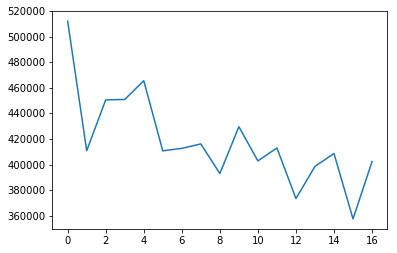

In [360]:
plt.plot(performance_PCA)

In [361]:
print(np.min(performance_PCA))
print(np.argmin(performance_PCA)+1)

357537.843427
16


In [364]:
pca = decomposition.PCA(n_components=15)
X_PCA =  pca.fit_transform(X)
X_restored = pca.inverse_transform(X_PCA)
rfg = RandomForestRegressor(max_depth=10, random_state=42,n_estimators=10)
rfg.fit(X_restored,y)

Xtest_PCA =  pca.fit_transform(X_test)
Xtest_restored = pca.inverse_transform(Xtest_PCA)
prediction = rfg.predict(Xtest_restored)

In [365]:
print('Mean Absolute Error: {}'.format(mean_absolute_error(validate, prediction)))
print('Mean Squared Error: {}'.format(mean_squared_error(validate, prediction)))
print('Root Mean Squared Error: {}'.format(np.sqrt(mean_squared_error(validate, prediction))))

Mean Absolute Error: 221312.13852395592
Mean Squared Error: 228071606340.40097
Root Mean Squared Error: 477568.43105506984


In [327]:
prediction = svr_lin.predict(Xtest_restored)

Mean Absolute Error: 181037.69416986743
Mean Squared Error: 206883137343.25476
Root Mean Squared Error: 454844.0802552615


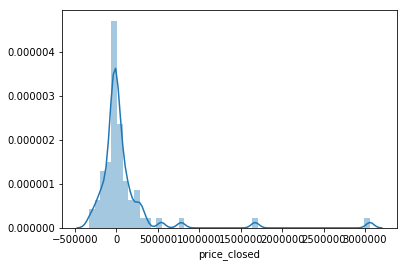

In [328]:
print('Mean Absolute Error: {}'.format(mean_absolute_error(validate, prediction)))
print('Mean Squared Error: {}'.format(mean_squared_error(validate, prediction)))
print('Root Mean Squared Error: {}'.format(np.sqrt(mean_squared_error(validate, prediction))))
sns.distplot((validate-prediction),bins=50) 

# Improve performance of Linear Regression

In [329]:
pca = decomposition.PCA(n_components=6)
X_PCA =  pca.fit_transform(X)
X_restored = pca.inverse_transform(X_PCA)
scores = cross_val_score(LinearRegression(normalize=True), X_restored, y, cv=10, scoring='neg_mean_squared_error')
np.mean(np.sqrt(-scores))

382243.42958059162

In [332]:
pipeline = Pipeline([('scaler', MinMaxScaler()),
                     ('pca',decomposition.PCA(n_components=6)),
                    ('linear', LinearRegression(normalize=True))])
scores = cross_val_score(pipeline, X, y, cv=10, scoring='neg_mean_squared_error')
np.mean(np.sqrt(-scores))

463017.31786192738

In [ ]:
#delete this

In [404]:
performance_PCA = []
for n in n_params:
    pca = decomposition.PCA(n_components=n)
    X_scaled = MinMaxScaler().fit_transform(X)
    X_PCA =  pca.fit_transform(X_scaled)
    X_restored = pca.inverse_transform(X_PCA)
    lasso = Lasso(normalize=True,alpha=0.0001).fit(X_restored,y)
    
    Xtest_scaled = MinMaxScaler().fit_transform(X_test)
    pca_test = decomposition.PCA(n_components=n)
    Xtest_PCA =  pca.fit_transform(Xtest_scaled)
    Xtest_restored = pca.inverse_transform(Xtest_PCA)
    prediction = lasso.predict(Xtest_restored)
    scores = np.sqrt(mean_squared_error(validate, prediction))
    performance_PCA.append(scores)

/anaconda/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:484: ConvergenceWarning:

Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.



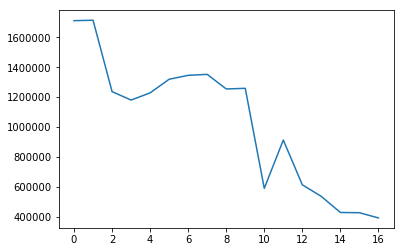

In [405]:
plt.plot(performance_PCA)

In [378]:
print(np.min(performance_PCA))
print(np.argmin(performance_PCA))

1479790.15435
0


In [410]:
pca = decomposition.PCA(n_components=16)
X_PCA =  pca.fit_transform(X)
X_restored = pca.inverse_transform(X_PCA)
lm = LinearRegression(normalize=True).fit(X_restored,y)

pca_test = decomposition.PCA(n_components=16)
Xtest_PCA =  pca.fit_transform(X_test)
Xtest_restored = pca.inverse_transform(Xtest_PCA)
prediction = lm.predict(Xtest_restored)
print('Mean Absolute Error: {}'.format(mean_absolute_error(validate, prediction)))
print('Mean Squared Error: {}'.format(mean_squared_error(validate, prediction)))
print('Root Mean Squared Error: {}'.format(np.sqrt(mean_squared_error(validate, prediction))))

Mean Absolute Error: 219569.50507582654
Mean Squared Error: 134069007356.80965
Root Mean Squared Error: 366154.3490890278


In [ ]:
# Effect on scaling

In [372]:
X_scaled = MinMaxScaler().fit_transform(X)
pca = decomposition.PCA(n_components=16)
X_PCA =  pca.fit_transform(X_scaled)
X_restored = pca.inverse_transform(X_PCA)
lm = LinearRegression(normalize=True).fit(X_restored,y)

pca_test = decomposition.PCA(n_components=16)
Xtest_scaled = MinMaxScaler().fit_transform(X_test)
Xtest_PCA =  pca.fit_transform(Xtest_scaled)
Xtest_restored = pca.inverse_transform(Xtest_PCA)
prediction = lm.predict(Xtest_restored)
lm = LinearRegression(normalize=True).fit(X_scaled,y)
prediction = lm.predict(Xtest_restored)

In [373]:
print('Mean Absolute Error: {}'.format(mean_absolute_error(validate, prediction)))
print('Mean Squared Error: {}'.format(mean_squared_error(validate, prediction)))
print('Root Mean Squared Error: {}'.format(np.sqrt(mean_squared_error(validate, prediction))))

Mean Absolute Error: 207416.67504943316
Mean Squared Error: 158160850909.3639
Root Mean Squared Error: 397694.4190070611


In [ ]:
#lasso

In [422]:
lasso = Lasso(normalize=True,alpha=0.0001).fit(X,y)
prediction = lasso.predict(X_test)
print('Mean Absolute Error: {}'.format(mean_absolute_error(validate, prediction)))
print('Mean Squared Error: {}'.format(mean_squared_error(validate, prediction)))
print('Root Mean Squared Error: {}'.format(np.sqrt(mean_squared_error(validate, prediction))))

Mean Absolute Error: 217188.6753319376
Mean Squared Error: 138041217367.28278
Root Mean Squared Error: 371538.984989843


In [421]:
X_scaled = MinMaxScaler().fit_transform(X)
Xtest_scaled = MinMaxScaler().fit_transform(X_test)
lasso = Lasso(normalize=True,alpha=0.0001).fit(X_scaled,y)
prediction = lasso.predict(Xtest_scaled)
print('Mean Absolute Error: {}'.format(mean_absolute_error(validate, prediction)))
print('Mean Squared Error: {}'.format(mean_squared_error(validate, prediction)))
print('Root Mean Squared Error: {}'.format(np.sqrt(mean_squared_error(validate, prediction))))

Mean Absolute Error: 208584.52966308547
Mean Squared Error: 152710915209.2173
Root Mean Squared Error: 390782.4397400903


In [ ]:
#with PCA

In [408]:
pca = decomposition.PCA(n_components=17)
X_PCA =  pca.fit_transform(X)
X_restored = pca.inverse_transform(X_PCA)
lasso = Lasso(normalize=True,alpha=0.0001).fit(X_restored,y)
Xtest_PCA = MinMaxScaler().fit_transform(X_test)
Xtest_restored = pca.inverse_transform(Xtest_PCA)
prediction = lasso.predict(Xtest_restored)

In [409]:
print('Mean Absolute Error: {}'.format(mean_absolute_error(validate, prediction)))
print('Mean Squared Error: {}'.format(mean_squared_error(validate, prediction)))
print('Root Mean Squared Error: {}'.format(np.sqrt(mean_squared_error(validate, prediction))))

Mean Absolute Error: 415736.47454905295
Mean Squared Error: 516276263426.8325
Root Mean Squared Error: 718523.6693574071


In [ ]:
#with scale

In [402]:
pca = decomposition.PCA(n_components=17)
X_scaled = MinMaxScaler().fit_transform(X)
X_PCA =  pca.fit_transform(X_scaled)
X_restored = pca.inverse_transform(X_PCA)
lasso = Lasso(normalize=True,alpha=0.0001).fit(X_restored,y)

Xtest_scaled = MinMaxScaler().fit_transform(X_test)
pca_test = decomposition.PCA(n_components=n)
Xtest_PCA =  pca.fit_transform(Xtest_scaled)
Xtest_restored = pca.inverse_transform(Xtest_PCA)
prediction = lasso.predict(Xtest_restored)

In [403]:
print('Mean Absolute Error: {}'.format(mean_absolute_error(validate, prediction)))
print('Mean Squared Error: {}'.format(mean_squared_error(validate, prediction)))
print('Root Mean Squared Error: {}'.format(np.sqrt(mean_squared_error(validate, prediction))))

Mean Absolute Error: 208584.529663085
Mean Squared Error: 152710915209.2169
Root Mean Squared Error: 390782.43974008976


In [ ]:
# ridge

In [381]:
Xtest_scaled = MinMaxScaler().fit_transform(X_test)
X_scaled = MinMaxScaler().fit_transform(X)
ridge = Ridge(normalize=True,alpha=1e-10).fit(X_scaled,y)
prediction = ridge.predict(Xtest_scaled)

In [382]:
print('Mean Absolute Error: {}'.format(mean_absolute_error(validate, prediction)))
print('Mean Squared Error: {}'.format(mean_squared_error(validate, prediction)))
print('Root Mean Squared Error: {}'.format(np.sqrt(mean_squared_error(validate, prediction))))

Mean Absolute Error: 208584.53379916417
Mean Squared Error: 152710915989.68356
Root Mean Squared Error: 390782.4407386846


In [383]:
Xtest_scaled = MinMaxScaler().fit_transform(X_test)
X_scaled = MinMaxScaler().fit_transform(X)
en = ElasticNet(normalize=True,alpha=1e-10,selection='random').fit(X_scaled,y)
prediction = en.predict(Xtest_scaled)
print('Mean Absolute Error: {}'.format(mean_absolute_error(validate, prediction)))
print('Mean Squared Error: {}'.format(mean_squared_error(validate, prediction)))
print('Root Mean Squared Error: {}'.format(np.sqrt(mean_squared_error(validate, prediction))))

Mean Absolute Error: 208584.53245272444
Mean Squared Error: 152710915634.03586
Root Mean Squared Error: 390782.44028363895


# Real Time Assessment

In [241]:
df2 = pd.read_csv('../data/test.csv')

In [242]:
df2.iloc[0]

id                                           207
bedrooms_total                                 4
baths_total                                    4
acres                                      10.16
sq_ft_tot_fn                                2804
 tax_gross_amount                          10425
assessment_value_town                     498600
garage_capacity                                2
address                  3101 Hartland Hill Road
city                                   Woodstock
garage_type                             Detached
year_built                                  1890
total_stories                                  2
surveyed                                     Yes
seasonal                                      No
water_body_type                              NaN
water_frontage_length                        NaN
short_sale                                   NaN
rooms_total                                    9
garage                                       Yes
flood_zone          

In [238]:
from fancyimpute import BiScaler, KNN

In [243]:
df2.rename(columns={' tax_gross_amount': 'tax_gross_amount'}, inplace=True)
df2['basement']= df2['basement'].map({'No':0,'Yes':1})
df2['garage']= df2['garage'].map({'No':0,'Yes':1})
df2['flood_zone']= df2['flood_zone'].map({'No':0,'Yes':1,'Unknown':1})
df2['current_use']= df2['current_use'].map({'No':0,'Yes':1,'Unknown':1})
df2['garage_type']= df2['garage_type'].map({'Attached':0,'Detached':1,'Under':2,'Carport':3})
df2['short_sale']=np.where(df2['short_sale']=='No', 0, 1)
df2['basement_access_type']= df2['basement_access_type'].map({'Interior':0,'Walkout':1,'Walk-up':2})
city2 = pd.get_dummies(df2.city,prefix='city_',drop_first=True)
covenants2 = pd.get_dummies(df2.covenants,prefix='covenants_',drop_first=True)
df2 = pd.concat([df2,city2,covenants2],axis=1)

In [251]:
X2=df2[['bedrooms_total', 'baths_total', 'acres', 'sq_ft_tot_fn',
       'tax_gross_amount', 'assessment_value_town', 'garage_capacity',
       'year_built', 'total_stories',
       'rooms_total', 'garage',
       'flood_zone',
       'basement', 'city__Pomfret', 'city__Woodstock',
       'covenants__Unknown', 'covenants__Yes']]

In [249]:
X_filled_knn = KNN(k=5).complete(X2)

Imputing row 1/23 with 1 missing, elapsed time: 0.003
[KNN] Warning: 23/414 still missing after imputation, replacing with 0


In [412]:
new = X2.loc[0]

In [413]:
pca_test = decomposition.PCA(n_components=16)
Xtest_PCA =  pca.fit_transform(new)
Xtest_restored = pca.inverse_transform(Xtest_PCA)

/anaconda/lib/python3.6/site-packages/sklearn/utils/validation.py:395: DeprecationWarning:

Passing 1d arrays as data is deprecated in 0.17 and will raise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.



In [414]:
prediction = lm.predict(Xtest_restored)

In [416]:
prediction - 390782.43974008976

array([ 206456.3595978])

In [423]:
prediction = lasso.predict(Xtest_restored)

In [425]:
prediction

array([ 579305.12965264])